In [1]:
import pandas as pd

data = pd.read_csv("../data/processed/merged/full_main.tsv", sep="\t")
data.lang_id.value_counts()

vie    1290
ara    1290
tur    1290
ukr    1290
nld    1290
ita    1290
Name: lang_id, dtype: int64

In [2]:
data['lang_id'] = data['lang_id'].map(
    {'ara': 'Arabic', 'ita': 'Italian', 'nld': 'Dutch', 'tur': 'Turkish', 'ukr': 'Ukrain.', 'vie': 'Vietnam.'}
)
data['task_type'] = data['task_type'].map(
    {'ht': 'From Scratch (HT)', 'pe1': 'Google Translate (PE1)', 'pe2': "mBART-50 (PE2)"}
)

In [3]:
def print_outliers(data, field, threshold_value, see_ids=False):
    print("Arabic", len(data[(data.lang_id == "Arabic") & (data.loc[:, field] > threshold_value)]))
    print("Italian", len(data[(data.lang_id == "Italian") & (data.loc[:, field] > threshold_value)]))
    print("Dutch", len(data[(data.lang_id == "Dutch") & (data.loc[:, field] > threshold_value)]))
    print("Turkish", len(data[(data.lang_id == "Turkish") & (data.loc[:, field] > threshold_value)]))
    print("Ukrainian", len(data[(data.lang_id == "Ukrain.") & (data.loc[:, field] > threshold_value)]))
    print("Vietnamese", len(data[(data.lang_id == "Vietnam.") & (data.loc[:, field] > threshold_value)]))
    if see_ids:
        print("Arabic", list(data[(data.lang_id == "Arabic") & (data.loc[:, field] > threshold_value)].item_id))
        print("Italian", list(data[(data.lang_id == "Italian") & (data.loc[:, field] > threshold_value)].item_id))
        print("Dutch", list(data[(data.lang_id == "Dutch") & (data.loc[:, field] > threshold_value)].item_id))
        print("Turkish", list(data[(data.lang_id == "Turkish") & (data.loc[:, field] > threshold_value)].item_id))
        print("Ukrainian", list(data[(data.lang_id == "Ukrain.") & (data.loc[:, field] > threshold_value)].item_id))
        print("Vietnamese", list(data[(data.lang_id == "Vietnam.") & (data.loc[:, field] > threshold_value)].item_id))

print_outliers(data, "time_m", 45, True)

Arabic 2
Italian 0
Dutch 0
Turkish 0
Ukrainian 0
Vietnamese 15
Arabic ['flores101-main-1003', 'flores101-main-541']
Italian []
Dutch []
Turkish []
Ukrainian []
Vietnamese ['flores101-main-1001', 'flores101-main-1021', 'flores101-main-1061', 'flores101-main-1072', 'flores101-main-1074', 'flores101-main-132', 'flores101-main-243', 'flores101-main-284', 'flores101-main-31', 'flores101-main-32', 'flores101-main-331', 'flores101-main-332', 'flores101-main-403', 'flores101-main-503', 'flores101-main-412']


In [4]:
outliers = [
    'flores101-main-1003', 'flores101-main-541', 'flores101-main-1001', 'flores101-main-1021', 'flores101-main-1061', 
    'flores101-main-1072', 'flores101-main-1074', 'flores101-main-132', 'flores101-main-243', 'flores101-main-284', 
    'flores101-main-31', 'flores101-main-32', 'flores101-main-331', 'flores101-main-332', 'flores101-main-403', 'flores101-main-503', 'flores101-main-412'
]
filtered_data = data[~data.item_id.isin(outliers)]
filtered_data.lang_id.value_counts()

Arabic      1239
Vietnam.    1239
Dutch       1239
Ukrain.     1239
Italian     1239
Turkish     1239
Name: lang_id, dtype: int64

In [5]:
# Compute productivity gains with respect to translation from scratch for every sentence
list_ht_prod = filtered_data[filtered_data.task_type == "From Scratch (HT)"][["lang_id", "item_id", "words_per_minute"]].to_dict(orient="records")
dic_ht_prod = {(x["lang_id"], x["item_id"]): x["words_per_minute"] for x in list_ht_prod}
filtered_data["delta_prod"] = filtered_data.apply(lambda x: (x["words_per_minute"] - dic_ht_prod[(x["lang_id"], x["item_id"])]) / abs(dic_ht_prod[(x["lang_id"], x["item_id"])]), axis=1)

/tmp/ipykernel_157200/2626347442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["delta_prod"] = filtered_data.apply(lambda x: (x["words_per_minute"] - dic_ht_prod[(x["lang_id"], x["item_id"])]) / abs(dic_ht_prod[(x["lang_id"], x["item_id"])]), axis=1)


In [6]:
# Regroup by document
doc_grouped = filtered_data.groupby(["doc_id", "subject_id", "lang_id", "task_type"]).sum()
doc_grouped.reset_index(level=[0,1,2,3], inplace=True)
doc_grouped.words_per_minute = doc_grouped.src_len_wrd / doc_grouped.time_m
doc_grouped.key_per_char = doc_grouped.k_total / doc_grouped.src_len_chr
doc_grouped.time_per_char = doc_grouped.time_s / doc_grouped.src_len_chr
doc_grouped.time_per_word = doc_grouped.time_s / doc_grouped.src_len_wrd

list_ht_prod_doc = filtered_data[filtered_data.task_type == "From Scratch (HT)"].groupby(["lang_id", "doc_id"]).sum().reset_index(level=[0,1])[["lang_id", "doc_id", "src_len_wrd", "time_m"]].to_dict(orient="records")
dic_ht_prod_doc = {(x["lang_id"], x["doc_id"]): x["src_len_wrd"] / x["time_m"] for x in list_ht_prod_doc}
doc_grouped.delta_prod = doc_grouped.apply(lambda x: (x["words_per_minute"] - dic_ht_prod_doc[(x["lang_id"], x["doc_id"])]) / abs(dic_ht_prod_doc[(x["lang_id"], x["doc_id"])]), axis=1)
doc_grouped.bleu = list(filtered_data.groupby(["doc_id", "subject_id", "lang_id", "task_type"]).mean()["bleu"])
doc_grouped.chrf = list(filtered_data.groupby(["doc_id", "subject_id", "lang_id", "task_type"]).mean()["chrf"])
doc_grouped.hter = list(filtered_data.groupby(["doc_id", "subject_id", "lang_id", "task_type"]).mean()["hter"])
doc_grouped.cer = list(filtered_data.groupby(["doc_id", "subject_id", "lang_id", "task_type"]).mean()["cer"])

# Plotting

In [7]:
import numpy as np
from plotnine import (
    ggplot, aes, geom_boxplot, labs, facet_grid, xlab, ylab, scale_y_continuous,
    ggtitle, scale_fill_brewer, element_blank, element_line, element_text, theme, annotate, scale_fill_manual, facet_wrap
)

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 27 rows containing non-finite values.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


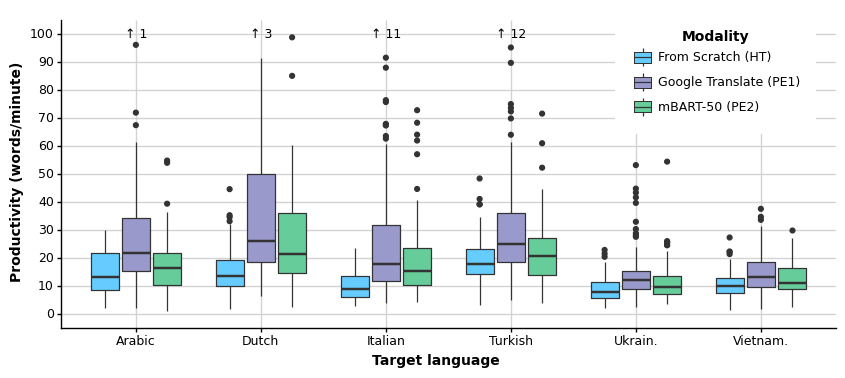

<ggplot: (8736207134338)>

In [8]:
plot = (
    ggplot(
        doc_grouped, aes("lang_id", "words_per_minute", fill="task_type")
    )
    + geom_boxplot()
    + xlab("Target language")
    + ylab("Productivity (words/minute)")
    + scale_y_continuous(breaks=np.arange(0, 105, 10),
        limits=[0, 100])
    + theme(
        legend_position=(0.78, 0.75),
        legend_title=element_text(size=10, face="bold", colour="black"),
        legend_text=element_text(size=9, colour="black"),
        legend_title_align="center",
        legend_box_spacing=0.4,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", face="bold"),
        text=element_text(family="Tahoma", size=9),
        axis_text_x=element_text(colour="black", size=9),
        axis_text_y=element_text(colour="black", size=9),
        figure_size=(10,4),
        axis_title=element_text(size=10, face="bold", colour="black"),
    )
    + scale_fill_manual(values=["#66CCFF", "#9999CC", "#66CC99"], name="Modality")
    + annotate("text", size=9, color = 'black', x = 1, y = 100, label="↑ 1")
    + annotate("text", size=9, color = 'black', x = 2, y = 100, label="↑ 3")
    + annotate("text", size=9, color = 'black', x = 3, y = 100, label="↑ 11")
    + annotate("text", size=9, color = 'black', x = 4, y = 100, label="↑ 12")
)
plot


In [202]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "productivity_per_document.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: productivity_per_document.pdf
/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 27 rows containing non-finite values.


/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 2 rows containing non-finite values.


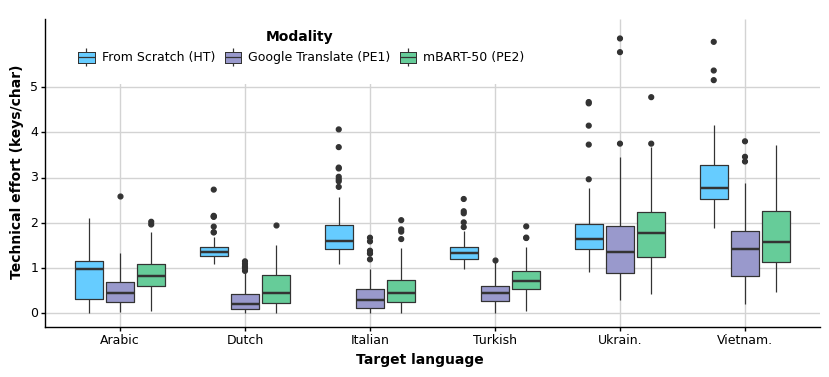

<ggplot: (8736204865067)>

In [9]:
plot = (
    ggplot(
        doc_grouped, aes("lang_id", "key_per_char", fill="task_type")
    )
    + geom_boxplot()
    + xlab("Target language")
    + ylab("Technical effort (keys/char)")
    + scale_y_continuous(breaks=np.arange(0, 6, 1), 
                     limits=[0, 6.2])
    + theme(
        legend_position=(0.38, 0.81),
        legend_direction="horizontal",
        legend_title=element_text(size=10, face="bold", colour="black"),
        legend_text=element_text(size=9, colour="black"),
        legend_title_align="center",
        legend_box_spacing=0.4,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", face="bold"),
        text=element_text(family="Tahoma", size=9),
        axis_text_x=element_text(colour="black", size=9),
        axis_text_y=element_text(colour="black", size=9),
        axis_title=element_text(size=10, face="bold", colour="black"),
        figure_size=(10,4)
    )
    + scale_fill_manual(values=["#66CCFF", "#9999CC", "#66CC99"], name="Modality")
)
plot

In [205]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "technical_effort.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: technical_effort.pdf
/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 2 rows containing non-finite values.


/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 24 rows containing non-finite values.


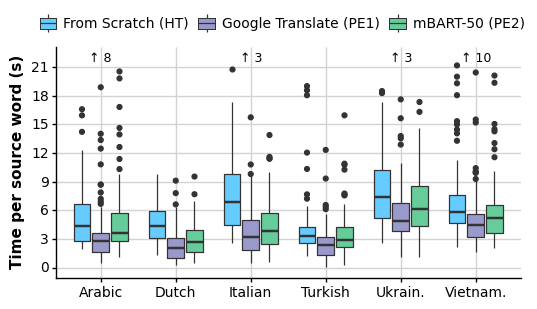

<ggplot: (8736204524978)>

In [14]:
import numpy as np
from plotnine import (
    ggplot, aes, geom_boxplot, labs, facet_grid, xlab, ylab, scale_y_continuous,
    ggtitle, scale_fill_brewer, element_blank, element_line, element_text, theme, annotate, scale_fill_manual
)

plot = (
    ggplot(# time_per_word
        doc_grouped, aes("lang_id", "time_per_word", fill="task_type")
    )
    + geom_boxplot()
    + xlab("Target language")
    + ylab("Time per source word (s)")
    + scale_y_continuous(breaks=np.arange(0, 22, 3),
        limits=[0, 22])
    + theme(
        legend_position=(0.5, 0.96),
        legend_title=element_blank(),#element_text(size=10, face="bold", colour="black"),
        legend_text=element_text(size=10, colour="black"),
        legend_title_align="center",
        legend_direction="horizontal",
        legend_box_spacing=0.05,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", face="bold"),
        text=element_text(family="Tahoma", size=10),
        axis_text_x=element_text(colour="black", size=10),
        axis_title_x = element_blank(),
        axis_text_y=element_text(colour="black", size=10),
        figure_size=(6,3),
        axis_title_y=element_text(size=11, face="bold", colour="black"),
        legend_box_margin=0.15,
    )
    + scale_fill_manual(values=["#66CCFF", "#9999CC", "#66CC99"], name="Modality")
    + annotate("text", size=9, color = 'black', x = 1, y = 22, label="↑ 8")
    + annotate("text", size=9, color = 'black', x = 3, y = 22, label="↑ 3")
    + annotate("text", size=9, color = 'black', x = 5, y = 22, label="↑ 3")
    + annotate("text", size=9, color = 'black', x = 6, y = 22, label="↑ 10")
)
plot

In [14]:
print_outliers(doc_grouped, "time_per_word", 22)

Arabic 8
Italian 0
Dutch 3
Turkish 0
Ukrainian 3
Vietnamese 10


In [15]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "time_per_src_word_small.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: time_per_src_word_small.pdf
/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 24 rows containing non-finite values.


In [17]:
full_groups = filtered_data[["subject_id", "task_type"]]
full_groups = full_groups[full_groups["task_type"] != "ht"]
filter_groups = filtered_data[filtered_data.tot_edits < 1][["subject_id", "task_type"]]
filter_groups = filter_groups[filter_groups["task_type"] != "ht"]
x = filter_groups.value_counts() / full_groups.value_counts()
x.fillna(0).to_csv("../outputs/out_edits_eval.csv")
x = pd.read_csv("../outputs/out_edits_eval.csv")
x["lang"] = x.subject_id.str.split("_").map(lambda x: x[0])
x['lang'] = x['lang'].map(
    {'ara': 'Arabic', 'ita': 'Italian', 'nld': 'Dutch', 'tur': 'Turkish', 'ukr': 'Ukrain.', 'vie': 'Vietnam.'}
)
x["subject_id"] = x.subject_id.str.split("_").map(lambda x: x[1])
x.rename({"0": "score"}, axis=1, inplace=True)
x.loc[x[(x.lang == "Italian") & (x.subject_id == "t5")].index, "subject_id"] = "t2"
x.loc[x[(x.lang == "Italian") & (x.subject_id == "t4")].index, "subject_id"] = "t3"
x["score"] = x["score"] * 100

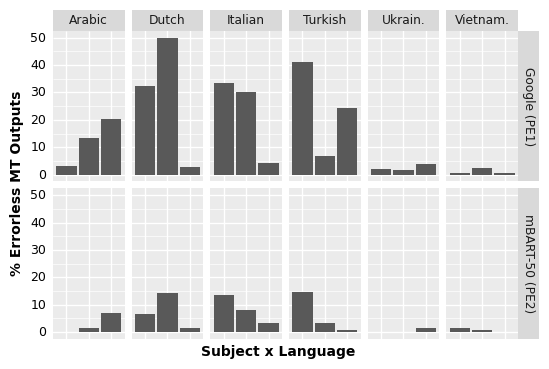

<ggplot: (8736203067350)>

In [22]:
from plotnine import geom_col, facet_grid

y = x.copy()
y['task_type'] = y['task_type'].map(
    {'From Scratch (HT)': 'ht', 'Google Translate (PE1)': 'Google (PE1)', "mBART-50 (PE2)": 'mBART-50 (PE2)'}
)

plot = (
    ggplot(
        y[y.task_type != "ht"], aes("subject_id", "score")
    )
    + geom_col()
    + facet_grid("task_type ~ lang")
    + xlab("Subject x Language")
    + ylab("% Errorless MT Outputs")
    + theme(
        axis_title=element_text(size=10, face="bold", colour="black"),
        axis_text_x=element_blank(),
        axis_text_y=element_text(size=9, colour="black"),
        axis_ticks=element_blank(),
        figure_size=(6,4)
    )
    + scale_fill_brewer(type="qual", palette="Accent", name="Translation setting")
)
plot

In [23]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "../outputs/errorless_outputs_small.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: ../outputs/errorless_outputs_small.pdf


/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 5 rows containing non-finite values.


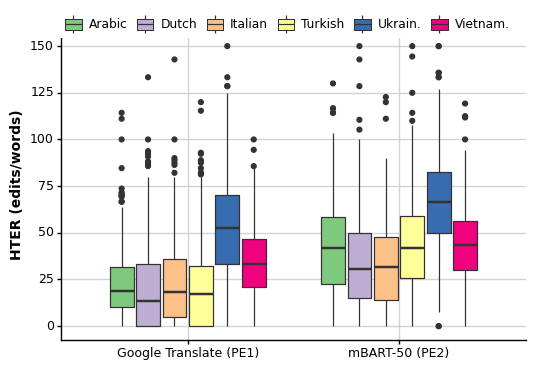

<ggplot: (8787520642033)>

In [10]:
from plotnine import guide_legend, guides

plot = (
    ggplot(
        filtered_data[filtered_data.task_type.isin(["Google Translate (PE1)", "mBART-50 (PE2)"])], aes("task_type", "hter", fill="lang_id")
    )
    + geom_boxplot()
    + xlab("NMT System")
    + ylab("HTER (edits/words)")
    + scale_y_continuous(limits=[0, 150], breaks=np.arange(0, 155, 25))
    + theme(
        legend_position=(0.50, 0.90),
        legend_direction="horizontal",
        legend_title_align="center",
        legend_box_spacing=0.05,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", face="bold"),
        #text=element_text(family="Tahoma", size=13),
        axis_text_x=element_text(colour="black", size=9),
        axis_text_y=element_text(colour="black", size=9),
        figure_size=(6,4),
        axis_title_y=element_text(size=10, face="bold", colour="black"),
        axis_title_x=element_blank(),
        legend_title=element_blank(),
        legend_box_margin=0.15,
    )
    + scale_fill_brewer(type="qual", palette="Accent", name="Language")
    + guides(fill = guide_legend(nrow=1))
)
plot

In [11]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "../outputs/hter_per_system.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: ../outputs/hter_per_system.pdf
/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 5 rows containing non-finite values.


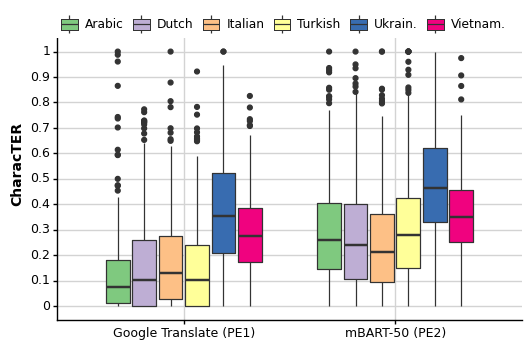

<ggplot: (8736204743687)>

In [27]:
from plotnine import guide_legend, guides

plot = (
    ggplot(
        filtered_data[filtered_data.task_type.isin(["Google Translate (PE1)", "mBART-50 (PE2)"])], aes("task_type", "cer", fill="lang_id")
    )
    + geom_boxplot()
    + xlab("NMT System")
    + ylab("CharacTER")
    + scale_y_continuous(limits=[0, 1.1], breaks=np.arange(0, 1.1, 0.1))
    + theme(
        legend_position=(0.50, 0.85),
        legend_direction="horizontal",
        legend_title_align="center",
        legend_box_spacing=0.05,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", face="bold"),
        #text=element_text(family="Tahoma", size=13),
        axis_text_x=element_text(colour="black", size=9),
        axis_text_y=element_text(colour="black", size=9),
        figure_size=(6,4),
        axis_title_y=element_text(size=10, face="bold", colour="black"),
        axis_title_x=element_blank(),
        legend_title=element_blank(),
        legend_box_margin=0.15,
    )
    + scale_fill_brewer(type="qual", palette="Accent", name="Language")
    + guides(fill = guide_legend(nrow=1))
)
plot

In [28]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "../outputs/cer_per_system.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: ../outputs/cer_per_system.pdf


In [18]:
doc_grouped[["lang_id", "subject_single_id"]] = doc_grouped.subject_id.str.split("_", expand=True)
doc_grouped['lang_id'] = doc_grouped['lang_id'].map({'ara': 'Arabic', 'ita': 'Italian', 'nld': 'Dutch', 'tur': 'Turkish', 'ukr': 'Ukrainian', 'vie': 'Vietnamese'})
doc_grouped.subject_single_id.replace({'t4': 't3', 't5': 't2'}, inplace=True)
doc_grouped.subject_single_id.replace({'t1': 'Subject 1', 't2': 'Subject 2', 't3': 'Subject 3'}, inplace=True)

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 24 rows containing non-finite values.


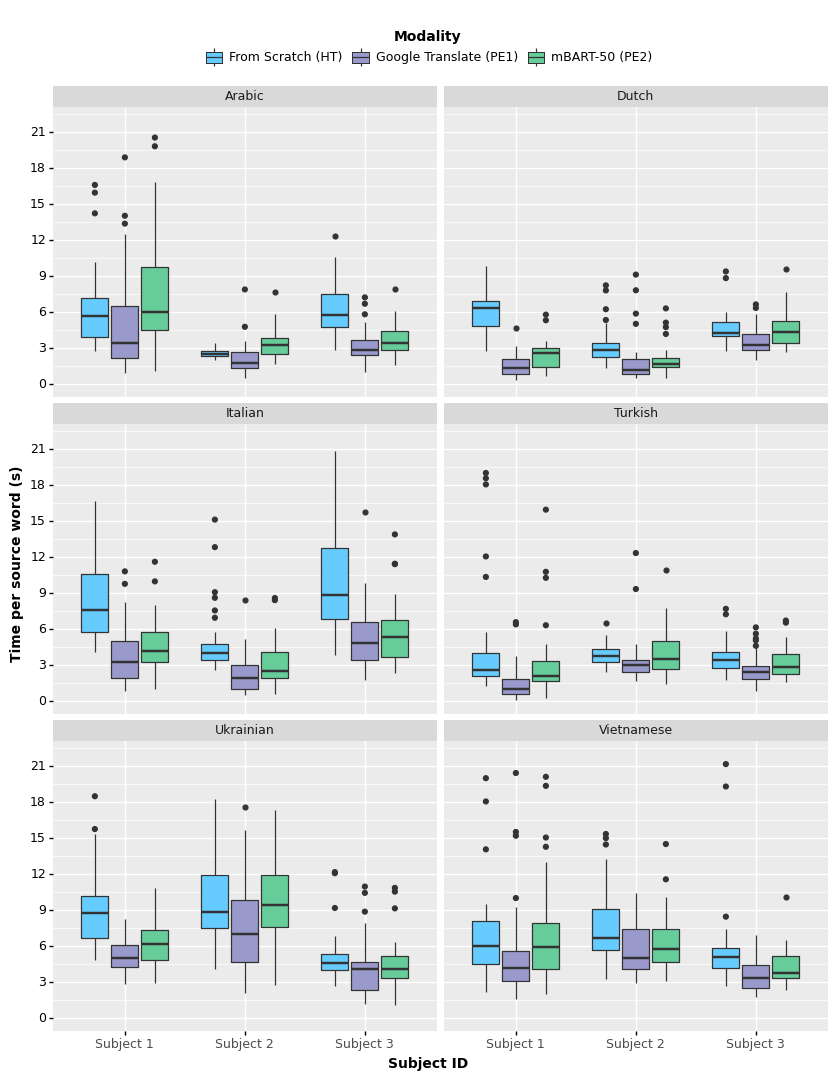

<ggplot: (8728312338755)>

In [19]:
plot = (
    ggplot(
        doc_grouped, aes("subject_single_id", "time_per_word", fill="task_type")
    )
    + geom_boxplot()
    + scale_fill_manual(values=["#66CCFF", "#9999CC", "#66CC99"], name="Modality")
    + facet_wrap("~ lang_id", nrow=3)
    + ylab("Time per source word (s)")
    + xlab("Subject ID")
    + scale_y_continuous(breaks=np.arange(0, 22, 3), 
                     limits=[0, 22])
    + theme(
        legend_position=(0.50, 0.93),
        legend_direction="horizontal",
        legend_title_align="center",
        legend_box_spacing=0.4,
        legend_title=element_text(size=10, face="bold", colour="black"),
        legend_key=element_blank(),
        text=element_text(family="Tahoma", size=9),
        axis_text_y=element_text(colour="black", size=9),
        figure_size=(10,12),
        axis_title=element_text(size=10, face="bold", colour="black"),
    )
)
plot

In [90]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot], "../outputs/trans_time_per_word_per_mode.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: ../outputs/trans_time_per_word_per_mode.pdf
/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 24 rows containing non-finite values.


# Scores and Correlations

In [9]:
lang_grouped_median = doc_grouped.groupby(["lang_id", "task_type"]).median()
lang_grouped_median.reset_index(level=[0,1], inplace=True)
lang_grouped_median[["lang_id", "task_type", "words_per_minute", "delta_prod", "hter", "cer"]]

,lang_id,task_type,words_per_minute,delta_prod,hter,cer
0,Arabic,From Scratch (HT),13.125376,0.000000,NaN,NaN
1,Arabic,Google Translate (PE1),21.726673,0.841105,19.485400,0.096628
2,Arabic,mBART-50 (PE2),16.287586,0.097658,41.387667,0.270816
3,Dutch,From Scratch (HT),13.621550,0.000000,NaN,NaN
4,Dutch,Google Translate (PE1),28.704447,1.185477,14.285667,0.102075
5,Dutch,mBART-50 (PE2),21.708249,0.606589,32.422750,0.238839
6,Italian,From Scratch (HT),8.760813,0.000000,NaN,NaN
7,Italian,Google Translate (PE1),18.600289,0.962913,19.192000,0.150653
8,Italian,mBART-50 (PE2),15.619779,0.949084,31.052750,0.233580
9,Turkish,From Scratch (HT),17.944462,0.000000,NaN,NaN


In [10]:
lang_grouped_mean = doc_grouped.groupby(["lang_id", "task_type"]).mean()
lang_grouped_mean.reset_index(level=[0,1], inplace=True)
lang_grouped_mean[["lang_id", "task_type", "words_per_minute", "delta_prod", "hter", "cer"]]

,lang_id,task_type,words_per_minute,delta_prod,hter,cer
0,Arabic,From Scratch (HT),15.140944,0.000000,NaN,NaN
1,Arabic,Google Translate (PE1),26.685869,1.490138,22.781066,0.126949
2,Arabic,mBART-50 (PE2),16.952308,0.463584,41.996365,0.284544
3,Dutch,From Scratch (HT),15.332657,0.000000,NaN,NaN
4,Dutch,Google Translate (PE1),44.861575,3.808754,20.776179,0.159465
5,Dutch,mBART-50 (PE2),27.256527,1.325363,34.399926,0.271256
6,Italian,From Scratch (HT),9.946033,0.000000,NaN,NaN
7,Italian,Google Translate (PE1),26.552826,2.614879,22.472132,0.168796
8,Italian,mBART-50 (PE2),19.867604,1.513266,32.817708,0.241942
9,Turkish,From Scratch (HT),19.324286,0.000000,NaN,NaN


In [8]:
lang_grouped_only_lang_mean = doc_grouped.groupby(["lang_id"]).mean()
lang_grouped_only_lang_mean.reset_index(level=[0], inplace=True)
lang_grouped_only_lang_mean[["lang_id", "hter", "cer"]]

,lang_id,hter,cer
0,Arabic,32.388716,0.205746
1,Dutch,27.588052,0.215361
2,Italian,27.644920,0.205369
3,Turkish,33.119641,0.232456
4,Ukrain.,58.961338,0.422195
5,Vietnam.,39.531362,0.325444


In [13]:
df_google = pd.DataFrame({
    "bleu": [34.1, 29.1, 32.8, 35, 31.1, 45.1],
    "chrf": [65.6, 60, 61.4, 65.5, 59.8, 61.9],
    "ter": [52.8, 58.5, 53.6, 50.4, 55.9, 41.8],
    "comet": [0.737, 0.667, 0.781, 1.000, 0.758, 0.724],
    "prod": [26.685, 44.86, 26.55, 64.66, 14.16, 14.86],
    "delta_prod": [1.49, 3.80, 2.61, 3.16, 0.97, 0.98],
    "hter": [22.78, 20.78, 22.47, 21.67, 51.39, 35.14],
    "cer": [0.127, 0.159, 0.169, 0.151, 0.364, 0.290]
})
df_google.corr()

,bleu,chrf,ter,comet,prod,delta_prod,hter,cer
bleu,1.000000,0.254851,-0.992012,0.067340,-0.298409,-0.517914,0.127038,0.254436
chrf,0.254851,1.000000,-0.328335,0.601047,0.449949,0.016493,-0.491775,-0.591422
ter,-0.992012,-0.328335,1.000000,-0.189357,0.219336,0.481177,-0.092242,-0.213708
comet,0.067340,0.601047,-0.189357,1.000000,0.649162,0.226509,-0.179088,-0.211636
prod,-0.298409,0.449949,0.219336,0.649162,1.000000,0.825964,-0.657686,-0.654199
delta_prod,-0.517914,0.016493,0.481177,0.226509,0.825964,1.000000,-0.734373,-0.677249
hter,0.127038,-0.491775,-0.092242,-0.179088,-0.657686,-0.734373,1.000000,0.967526
cer,0.254436,-0.591422,-0.213708,-0.211636,-0.654199,-0.677249,0.967526,1.000000


In [14]:
df_mbart = pd.DataFrame({
    "bleu": [17, 22.6, 24.4, 18.8, 21.9, 34.7],
    "chrf": [48.5, 53.9, 54.7, 52.7, 50.7, 54],
    "ter": [69.1, 63.7, 61.2, 67.5, 67.9, 50.7],
    "comet": [0.452, 0.532, 0.648, 0.755, 0.587, 0.608],
    "prod": [16.95, 27.26, 19.87, 25.96, 11.47, 12.56],
    "delta_prod": [0.46, 1.33, 1.51, 0.60, 0.56, 0.53],
    "hter": [42, 34.40, 32.82, 44.57, 66.53, 43.93],
    "cer": [0.285, 0.271, 0.242, 0.314, 0.481, 0.361]
    
})
df_mbart.corr()

,bleu,chrf,ter,comet,prod,delta_prod,hter,cer
bleu,1.000000,0.612593,-0.974188,0.138430,-0.417451,0.050335,-0.074185,0.164183
chrf,0.612593,1.000000,-0.656037,0.544794,0.342025,0.668030,-0.491327,-0.318828
ter,-0.974188,-0.656037,1.000000,-0.140016,0.286952,-0.113750,0.277238,0.046728
comet,0.138430,0.544794,-0.140016,1.000000,0.266192,0.079479,0.033419,0.048996
prod,-0.417451,0.342025,0.286952,0.266192,1.000000,0.512679,-0.624904,-0.671635
delta_prod,0.050335,0.668030,-0.113750,0.079479,0.512679,1.000000,-0.640778,-0.598382
hter,-0.074185,-0.491327,0.277238,0.033419,-0.624904,-0.640778,1.000000,0.966830
cer,0.164183,-0.318828,0.046728,0.048996,-0.671635,-0.598382,0.966830,1.000000


# Questionnaires

In [1]:
import pandas as pd

pre = pd.read_csv("../data/questionnaire/pre_task.tsv", sep="\t")
post = pd.read_csv("../data/questionnaire/post_task.tsv", sep="\t")

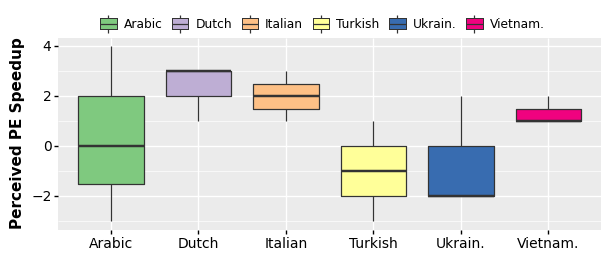

<ggplot: (8776916510600)>

In [22]:
from plotnine import guide_legend, guides

post["mt_rank_speed_diff"] = post["mt_rank_speed_pe"] - post["mt_rank_speed_ht"]

post_melted_temp = pd.melt(
    post,
    id_vars=['lang_id'],
    value_vars=['mt_rank_speed_diff'],
    var_name="modality",
    value_name="temporal_effort"
)
post_melted_temp["lang_id"] = post_melted_temp["lang_id"].map(
    {'ara': 'Arabic', 'ita': 'Italian', 'nld': 'Dutch', 'tur': 'Turkish', 'ukr': 'Ukrain.', 'vie': 'Vietnam.'}
)
post_melted_temp["modality"] = post_melted_temp["modality"].map(
    {'mt_rank_speed_diff': 'Speed Increase'}
)

plot2 = (
    ggplot(
        post_melted_temp, aes("lang_id", "temporal_effort", fill="lang_id")
    )
    + geom_boxplot()
    + xlab("Setting")
    + ylab("Perceived PE Speedup")
    + theme(
        legend_position=(0.50, 0.935),
        legend_direction="horizontal",
        legend_box_spacing=0.05,
        legend_key=element_blank(),
        axis_text_x=element_text(colour="black", size=10),
        axis_text_y=element_text(colour="black", size=10),
        figure_size=(7,2.5),
        axis_title_y=element_text(size=11, face="bold", colour="black"),
        axis_title_x=element_blank(),
        legend_title=element_blank(),
        legend_box_margin=0.15,
    )
    + scale_fill_brewer(type="qual", palette="Accent", name="Language")
    + guides(fill = guide_legend(nrow=1))
)
plot2

In [23]:
from plotnine import save_as_pdf_pages

save_as_pdf_pages([plot2], "../outputs/perceived_pe_speedup.pdf")

/home/gsarti/projects/venv/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: ../outputs/perceived_pe_speedup.pdf


In [24]:
post.corr()

,mt_rating,diff_mt,issues_order,issues_morph,issues_mistrans,issues_add,issues_term,issues_syntax,issues_verbs,issues_punct,...,mt_rank_speed_ht,mt_rank_speed_pe,mt_rank_cog_effort_ht,mt_rank_cog_effort_pe,mt_rank_tech_effort_ht,mt_rank_tech_effort_pe,mt_rank_pref_ht,mt_rank_pref_pe,duration_s,mt_rank_speed_diff
mt_rating,1.000000,NaN,-0.192677,0.131085,-0.597348,-0.254082,-0.024940,-0.434990,-0.290389,-0.107789,...,-0.340915,0.741651,0.047291,-0.091132,-0.083056,0.424611,0.067850,0.759264,-0.237797,0.693153
diff_mt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
issues_order,-0.192677,NaN,1.000000,0.419961,0.265317,-0.098844,-0.331890,0.651852,0.029654,0.300198,...,0.132865,-0.363105,0.077162,-0.040921,0.322302,-0.353757,0.000000,-0.440385,-0.298776,-0.320488
issues_morph,0.131085,NaN,0.419961,1.000000,0.175491,0.186797,-0.020907,0.309958,0.100874,0.363085,...,0.100437,-0.088226,0.174987,0.255202,-0.026104,0.025070,-0.206631,-0.105126,-0.354283,-0.127190
issues_mistrans,-0.597348,NaN,0.265317,0.175491,1.000000,0.219827,0.131844,0.379534,0.339471,0.043572,...,0.450564,-0.442500,-0.015152,0.344124,0.091474,-0.365617,0.007033,-0.497214,0.094627,-0.595383
issues_add,-0.254082,NaN,-0.098844,0.186797,0.219827,1.000000,0.042454,0.165053,0.636229,0.102633,...,0.139054,-0.130292,0.050473,-0.032121,-0.195161,-0.219827,-0.017165,-0.094606,0.136314,-0.181125
issues_term,-0.024940,NaN,-0.331890,-0.020907,0.131844,0.042454,1.000000,-0.040641,0.156313,0.386810,...,-0.104507,0.124597,0.382726,0.172409,0.301709,-0.163297,-0.199676,0.347242,-0.016808,0.151196
issues_syntax,-0.434990,NaN,0.651852,0.309958,0.379534,0.165053,-0.040641,1.000000,0.114881,0.390330,...,0.269193,-0.258121,0.378811,0.321158,0.487445,-0.379534,-0.076683,-0.422643,0.202260,-0.354277
issues_verbs,-0.290389,NaN,0.029654,0.100874,0.339471,0.636229,0.156313,0.114881,1.000000,0.316706,...,-0.193988,-0.241864,-0.047244,-0.356551,-0.065056,-0.445686,-0.073811,-0.010916,-0.166154,-0.009057
issues_punct,-0.107789,NaN,0.300198,0.363085,0.043572,0.102633,0.386810,0.390330,0.316706,1.000000,...,-0.264654,-0.093981,0.522412,0.193805,0.436126,-0.186938,-0.215475,0.165028,-0.115722,0.133449
